# CartPole-Reinforcement-Learning
Modified from TensorFlow, Reinforcement learning approach for CartPole environment.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,898 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,356 kB]
Fetched 3,483 kB in 2s (1,872 kB/s)
Reading package lists... Done
Reading

#Importing Libraries

In [ ]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import reverb
import base64
import imageio
import IPython
import matplotlib
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

In [ ]:
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec  # Add the missing import
from tf_agents.utils import common



In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

tf.version.VERSION

'2.15.0'

## Hyperparameters

In [ ]:
# Modify Hyperparameters
learning_rate = 2e-3  # Correct notation for a small learning rate
num_iterations = 10000  # Reduce training iterations
sequence_length = 4   # Adjust sequence length
initial_collect_steps = 1000 # Increase initial collection steps
collect_steps_per_iteration = 1  # Increase collection steps per iteration
replay_buffer_max_length = 1000000  # Increase replay buffer length

batch_size = 64  # Increase batch size for faster training
#learning_rate = 1e-4  # Assign the learning rate correctly

log_interval = 200  # Adjust log interval

num_eval_episodes = 20  # Increase number of evaluation episodes
eval_interval = 1000  # Adjust evaluation interval

gamma = 0.99  # Discount factor for future rewards
epsilon_initial = 1.0  # Initial value of epsilon for epsilon-greedy exploration
epsilon_decay = 0.99  # Decay rate for epsilon
epsilon_min = 0.01  # Minimum value of epsilon

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite.

In [ ]:
# Environment
env_name = 'CartPole-v0'  # Change environment to MountainCar
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [ ]:
# Determine number of actions based on the action specification of the environment
action_tensor_spec = env.action_spec()
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

## Agent

In [ ]:
# Neural Network
dense_layers = [
    tf.keras.layers.Dense(units=512, activation='relu'),  # Increase units for more capacity
    tf.keras.layers.Dense(units=256, activation='relu'),   # Add dense layer
    tf.keras.layers.Dense(units=64, activation='relu'),

]

q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2.0, mode='fan_in', distribution='truncated_normal'),  # Adjust kernel initializer
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])


In [ ]:
# Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

In [ ]:
# Policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [ ]:
# Random policy for comparison
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


## Metrics and Evaluation


In [ ]:
# Metrics and Evaluation
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

22.45

## Replay Buffer

In [ ]:

# Replay Buffer
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)


table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


##Data Collection

In [ ]:
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
# Data Collection

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([0.00808328, 0.04536255, 0.0524893 , 0.07947939], dtype=float32)}),
 ())

In [ ]:
# Dataset
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

## Training the agent

In [ ]:
iterator = iter(dataset)

# Training the Agent
try:
    %%time
except:
    pass

agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration
)

for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 63.03820037841797
step = 400: loss = 28.91181755065918
step = 600: loss = 39.88565444946289
step = 800: loss = 90.62760925292969
step = 1000: loss = 118876.40625
step = 1000: Average Return = 71.6500015258789
step = 1200: loss = 215651.34375
step = 1400: loss = 884735.4375
step = 1600: loss = 7626453.0
step = 1800: loss = 111605184.0
step = 2000: loss = 75815248.0
step = 2000: Average Return = 180.85000610351562
step = 2200: loss = 4625977856.0
step = 2400: loss = 1172174208.0
step = 2600: loss = 32080261120.0
step = 2800: loss = 59587010560.0
step = 3000: loss = 25297817600.0
step = 3000: Average Return = 199.85000610351562
step = 3200: loss = 24067522560.0
step = 3400: loss = 9629621248.0
step = 3600: loss = 93270269952.0
step = 3800: loss = 592313057280.0
step = 4000: loss = 106886955008.0
step = 4000: Average Return = 199.6999969482422
step = 4200: loss = 455470612480.0
step = 4400: loss = 2417462607872.0
step = 4600: loss = 5177452527616.0
step = 4800: loss = 15

## Visualization


### Graphical Plots and Video

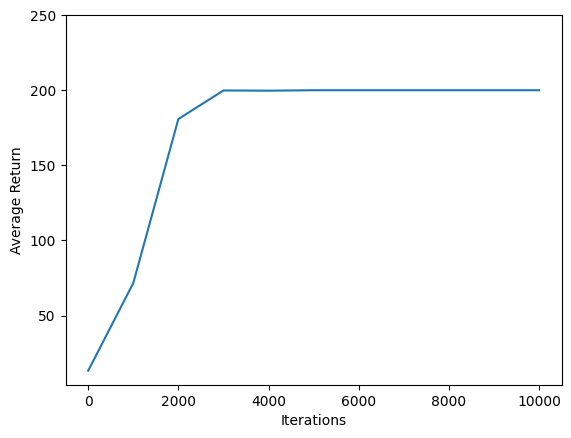

In [ ]:
import matplotlib.pyplot as plt
import imageio

# Visualization
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=150, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

create_policy_eval_video(random_policy, "random-agent")


# The model testing

In [ ]:
# Model Testing
def test_agent(num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = agent.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

num_test_episodes = 20  # Number of episodes to run during testing
average_return_test = test_agent(num_test_episodes)
print('Average Return during Testing: {}'.format(average_return_test))


Average Return during Testing: 200.0


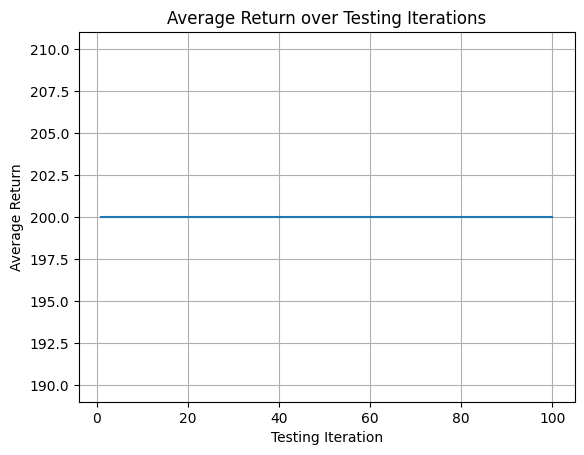

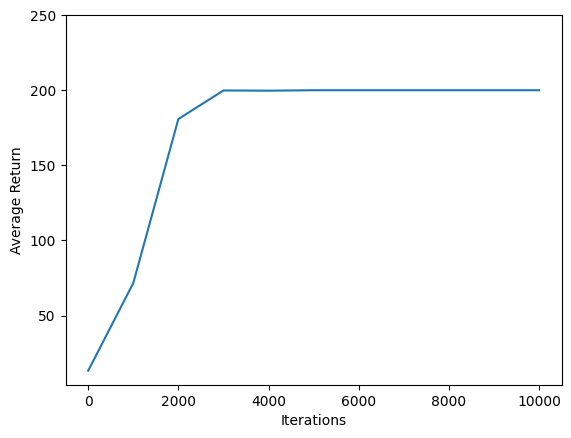

In [ ]:
# The number of testing iterations
num_test_iterations = 100

# Testing the Agent
test_returns = []

for _ in range(num_test_iterations):
    time_step = eval_env.reset()
    episode_return = 0.0

    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        episode_return += time_step.reward

    test_returns.append(episode_return.numpy()[0])

# Plotting the average return over testing iterations
plt.plot(range(1, num_test_iterations + 1), test_returns)
plt.xlabel('Testing Iteration')
plt.ylabel('Average Return')
plt.title('Average Return over Testing Iterations')
plt.grid(True)
plt.show()

# Visualization
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=10, fps=10):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "test-agent")

create_policy_eval_video(random_policy, "random-agent")
